# **FINAL PROJECT**

## Digital Signal Processing

### Electroencephalogram: Motor Imaginery classifier
<img style="float: right; padding-right: 10px;" height="220" src="https://drive.google.com/uc?id=0BzGoTc_BVojJUGJvMWRQVVllV0U"> <br>**Universidad del Valle** <br>

**Electric and Electronic Engineering School**

Juan Esteban Montenegro
<br>

---



# Introduction

Imagine controlling a virtual avatar with your mind, effortlessly manipulating objects or navigating landscapes by simply picturing the movements of your hands. Or envision regaining some control over paralyzed limbs through the power of thought, directing a prosthetic foot with the same intuitive ease as your own. Brain-computer interfaces (BCIs) hold immense promise for revolutionizing rehabilitation, prosthetics, and even virtual reality experiences. However, a crucial roadblock stands in the way: accurately deciphering the intricate language of our thoughts, particularly when it comes to distinguishing between different body parts.

While BCI research has achieved remarkable feats, primarily focusing on hand movements, differentiating the subtle neural signatures of hands versus feet remains a significant challenge. This is akin to trying to distinguish between the whispers of two close friends in a crowded room - their voices may be similar, but the nuances in tone and inflection reveal their distinct identities. Similarly, the brain's activity patterns for hands and feet, while related, hold subtle differences that current BCI systems often struggle to discern.

This limitation significantly hinders the development of BCIs for crucial applications. Imagine a paraplegic hoping to control a prosthetic foot using motor imagery; if the BCI misinterprets their thoughts, the resulting movement could be awkward, even detrimental. In virtual reality, the inability to differentiate between imagined hand and foot movements would translate to clunky, unrealistic avatar interactions, shattering the immersive experience.

# Problem statement

This limitation hinders the development of BCIs for crucial applications like rehabilitation, prosthetics control, and immersive virtual reality experiences. Addressing this challenge requires the development of robust algorithms that can discern the finer nuances of brain activity for different limbs, generalizing effectively across diverse individuals and contexts.

Achieving this objective would not only advance our understanding of motor control but also unlock a new frontier in BCI technology, enabling enhanced control and interaction with the world around us through mental imagination. By focusing on the hands-feet motor imagery problem, we can pave the way for a future where brain-powered interfaces seamlessly integrate with various domains, revolutionizing rehabilitation, human-computer interaction, and our understanding of the brain itself.

# Objectives
Develop an accurate and efficient EEG signal classification system based on motor imagery for hands and feet.

*  Implement algorithms to clean and prepare EEG signals for analysis, addressing noise, artifacts, and inconsistencies.

*  Extract relevant features from the processed EEG signals, including time-domain, frequency-domain, and spatial characteristics, that effectively distinguish between normal and pathological brain activity.

*  Implement a classification algorithm to accurately categorize ECG signals into hands and feets motor imaginery signals.

* Create clear and informative visualizations of both the raw EEG signals and the classification results.

* Generate a summary table presenting the system's success and failure rates in recognizing each of the three classes, enabling performance assessment.

# Table of Content

*   Data acquisition
*   Preprocessing
*   Feature extraction
*   Classification
*   Visualization and Interpretation


---




**Imports**

Import all other necessary modules

In [110]:
import os.path as op

from math import pi

import numpy as np

from scipy import signal
from scipy.integrate import simps

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
%matplotlib inline

# Data acquisition
This initial stage establishes the foundation for our analysis by acquiring electroencephalographic (EEG) recordings. These can be sourced from readily available databases, encompassing diverse neurological states, or from controlled experimental settings under specific protocols. The selection and quality of the acquired data will significantly influence the generalizability and accuracy of subsequent analysis.

* Install MNE module (Open-source Python package for exploring, visualizing, and analyzing human neurophysiological data: MEG, EEG, sEEG, ECoG, NIRS, and more).

In [111]:
try:
  import mne
except ModuleNotFoundError:
  !pip install mne
  import mne
  pass
from mne import (Epochs, pick_types)
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.io import (concatenate_raws, read_raw_edf)

In [112]:
event_dict = {
    "Baseline, eyes open": 1,
    "Baseline, eyes closed": 2,
    "Motor execution: left vs right hand": [3, 7, 11],
    "Motor imagery: left vs right hand": [4, 8, 12],
    "Motor execution: hands vs feet": [5, 9, 13],
    "Motor imagery: hands vs feet": [6, 10, 14],
}

In [113]:
subject = 1
runs = event_dict['Motor imagery: hands vs feet']   # motor imagery: hands vs feet
print('Events:',runs)

Events: [6, 10, 14]


In [114]:
raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)
raw.annotations.rename(dict(T1="hands", T2="feet"))

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


<Annotations | 94 segments: BAD boundary (2), EDGE boundary (2), T0 (45), ...>

## Plot Data

Effective window size : 12.800 (s)


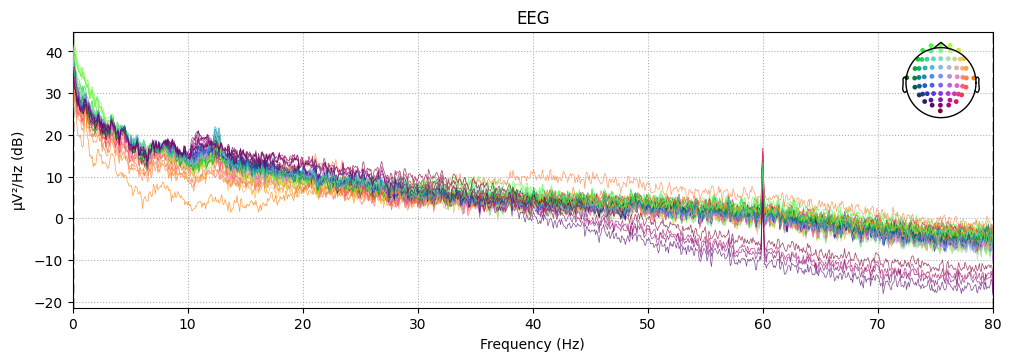

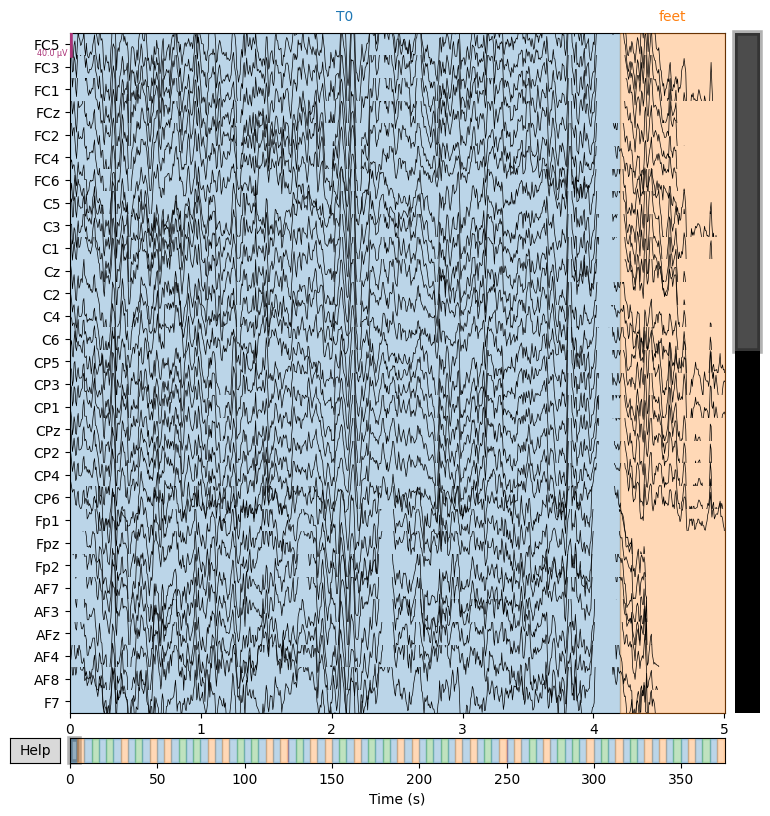

In [115]:
raw.compute_psd().plot(picks="data", exclude="bads")
raw.plot(duration=5, n_channels=30)
print()

We can observe some noise at 60 Hz which corresponds to power line frequency

## Extract data

In [116]:
info = raw.info
FS = info["sfreq"]
n_time_samps = raw.n_times
time_secs = raw.times
ch_names = raw.ch_names
n_chan = len(ch_names)

In [117]:
print(
    "the (cropped) sample data object has {} time samples and {} channels."
    "".format(n_time_samps, n_chan)
)
print("The last time sample is at {} seconds.".format(time_secs[-1]))
print("The first few channel names are {}.".format(", ".join(ch_names[:3])))
print()  # insert a blank line in the output

# some examples of raw.info:
print("bad channels:", info["bads"])  # chs marked "bad" during acquisition
print("Sampling frequency:",info["sfreq"], "Hz")  # sampling frequency
print(info["description"], "\n")  # miscellaneous acquisition info
print(info)

the (cropped) sample data object has 60000 time samples and 64 channels.
The last time sample is at 374.99375 seconds.
The first few channel names are FC5, FC3, FC1.

bad channels: []
Sampling frequency: 160.0 Hz
None 

<Info | 9 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: 3 items (dict)
>


In [118]:
print('No Channels:',len(ch_names))
print(ch_names)

No Channels: 64
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FT8', 'T7', 'T8', 'T9', 'T10', 'TP7', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz']


# Preprocessing
Prior to feature extraction, the raw EEG signals must undergo meticulous preprocessing to mitigate inherent noise and artifacts. This encompasses techniques like filtering to remove power line interference and muscular activity, as well as independent component analysis to segregate independent sources within the brain activity. Effective preprocessing ensures reliable and interpretable features for subsequent analysis.

## DC offset

Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 5281 samples (33.006 s)



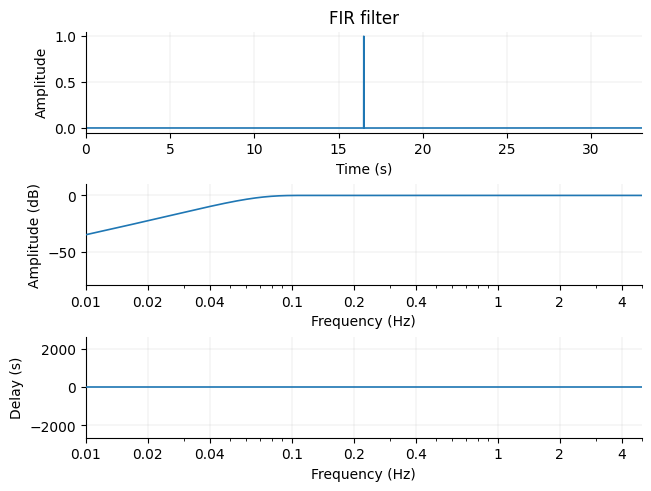

In [119]:
filter_params = mne.filter.create_filter(
    raw.get_data(), raw.info["sfreq"], l_freq=0.1, h_freq=None
)
mne.viz.plot_filter(filter_params, raw.info["sfreq"], flim=(0.01, 5))
print()

In [120]:
balanced_signal = raw.copy().filter(l_freq=0.1, h_freq=None)

Filtering raw data in 3 contiguous segments
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 5281 samples (33.006 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Effective window size : 12.800 (s)



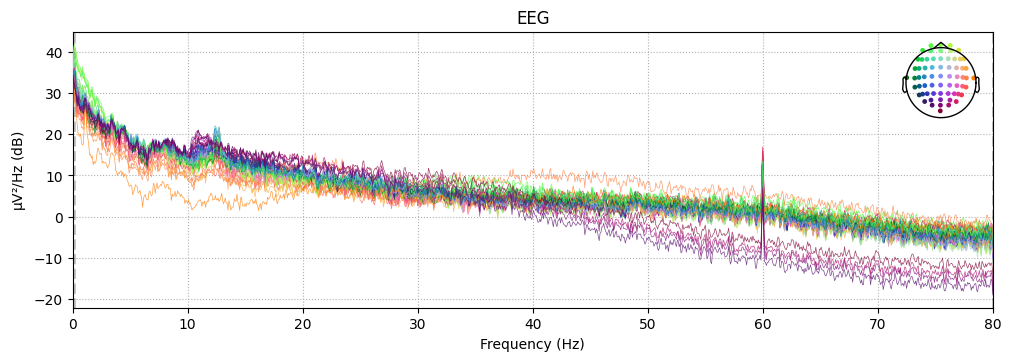

In [121]:
balanced_signal.compute_psd().plot(picks="data", exclude="bads")
print()

## Filtering

* **FIR filter description using convolution**
\begin{align}
  y(n)=\sum_{k=0}^{M-1}{h(k)*x(n-k)}
\end{align}
where,
 *   $h(k) = b_{k}$, $h(n)=\{{b_{0}, b_{1},\ldots, b_{M-1} }\}$
 *   $k=0,1,\ldots,M-1$


* **Hamming window for** $h(n),{0}\leq{n}\leq{M-1}$
\begin{align}
  w(n)=0.54-0.46*cos\dfrac{2\pi n}{M-1}
\end{align}

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)



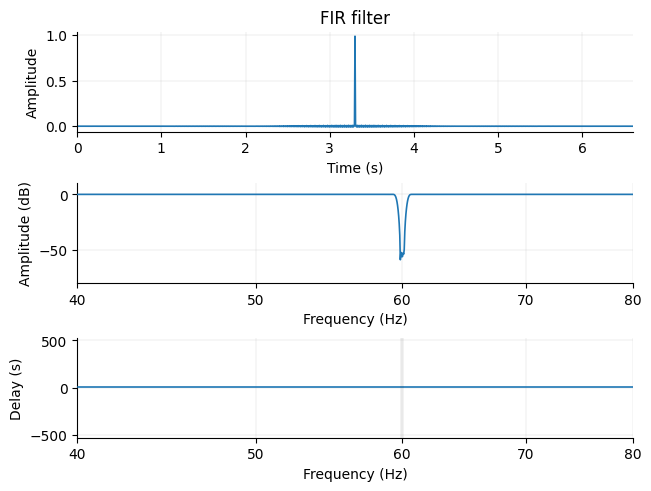

In [122]:
filter_params = mne.filter.create_filter(
    balanced_signal.get_data(),
    balanced_signal.info["sfreq"],
    l_freq=60.65,
    h_freq=59.35,
    l_trans_bandwidth=0.50,
    h_trans_bandwidth=0.50,
    filter_length='auto'
)
mne.viz.plot_filter(filter_params, balanced_signal.info["sfreq"], flim=(40, 80))
print()

In [123]:
raw_filtered = balanced_signal.copy().notch_filter(
    [60],
    picks=['eeg'],
    filter_length='auto',
    phase='zero')
print()

Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Effective window size : 12.800 (s)



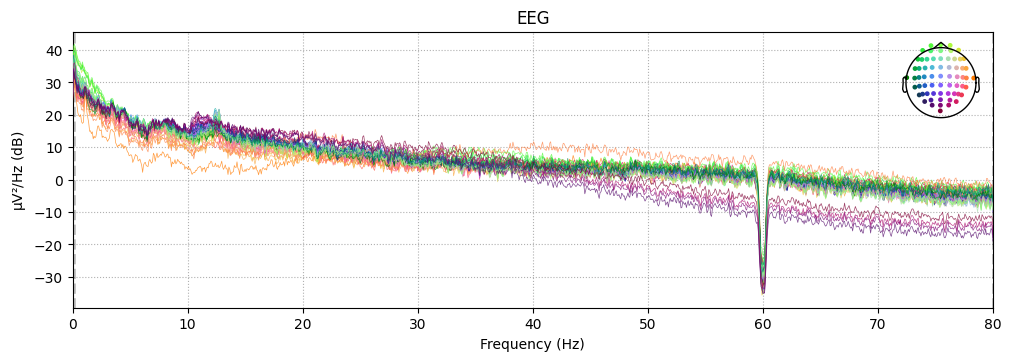

In [124]:
raw_filtered.compute_psd().plot(picks="data", exclude="bads")
print()

In [125]:
# Apply band-pass filter
raw_filtered.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Measurement date,"August 12, 2009 16:15:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,67 points
Good channels,64 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,160.00 Hz
Highpass,7.00 Hz
Lowpass,30.00 Hz


Effective window size : 12.800 (s)



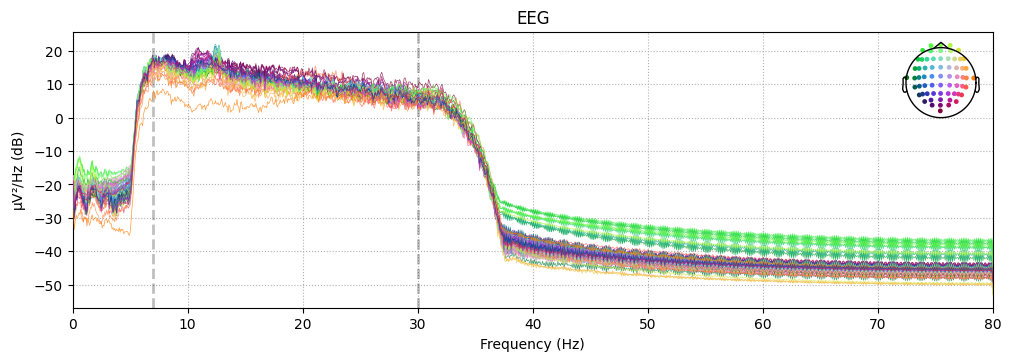

In [126]:
raw_filtered.compute_psd().plot(picks="data", exclude="bads")
print()

# Feature extraction
This crucial stage involves transforming the preprocessed EEG signals into a set of quantitative descriptors that capture their essential characteristics. Common features include time-domain measures like mean and variance, frequency-domain analysis like power spectral density and dominant frequency, and spatial features like coherence and connectivity measures. The choice of extracted features will depend on the specific classification task and the underlying neurophysiological phenomena of interest.



In [127]:
eeg_channel_indices = pick_types(raw_filtered.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

eeg_data_filtered, times = raw_filtered[eeg_channel_indices]

## Time-Domain features

In [128]:
# Mean
mean_value = np.mean(eeg_data_filtered)

# Standard deviation
std_value = np.std(eeg_data_filtered)

# Variance
var_value = np.var(eeg_data_filtered)

# Root mean square (RMS)
rms_value = np.sqrt(np.mean(eeg_data_filtered**2))

print('Mean',mean_value)
print('Standard deviation',std_value)
print('Variance:',var_value)
print('Root mean square (RMS):',rms_value)

Mean 2.3362968105428834e-10
Standard deviation 2.0880626336140728e-05
Variance: 4.360005561895338e-10
Root mean square (RMS): 2.088062633744775e-05


## Frequecy-Domain features

In [129]:
# Power spectral density (PSD)
freqs, psds = signal.welch(eeg_data_filtered, fs=FS, window='hamming')

# Frequency resolution
freq_res = freqs[1] - freqs[0]
print('Frequency resolution:', freq_res)

delta_power = np.zeros(psds.shape[0])
theta_power = np.zeros(psds.shape[0])
alpha_power = np.zeros(psds.shape[0])
beta_power = np.zeros(psds.shape[0])
gamma_power = np.zeros(psds.shape[0])

# Find closest indices of band in frequency vector
idx_delta = np.logical_and(freqs >= 0.5, freqs <= 4)
idx_theta = np.logical_and(freqs >= 4, freqs <= 8)
idx_alpha = np.logical_and(freqs >= 8, freqs <= 12)
idx_beta  = np.logical_and(freqs >= 12, freqs <= 30)
idx_gamma = np.logical_and(freqs >= 30, freqs <= 100)

# Band power features (e.g., delta, theta, alpha, beta, gamma)
for i, psd in enumerate(psds):
  delta_power[i] = simps(psd[idx_delta], dx=freq_res)
  theta_power[i] = simps(psd[idx_theta], dx=freq_res)
  alpha_power[i] = simps(psd[idx_alpha], dx=freq_res)
  beta_power[i]  = simps(psd[idx_beta], dx=freq_res)
  gamma_power[i] = simps(psd[idx_gamma], dx=freq_res)

Frequency resolution: 0.625


In [130]:
def plotPowerSpectrum(freqs, psds):
  fig = plt.figure()
  for psd in psds:
    plt.semilogy(freqs, np.sqrt(psd))
  plt.xlabel('frequency [Hz]')
  plt.ylabel('Linear spectrum [V RMS]')
  plt.show()
  plt.close()

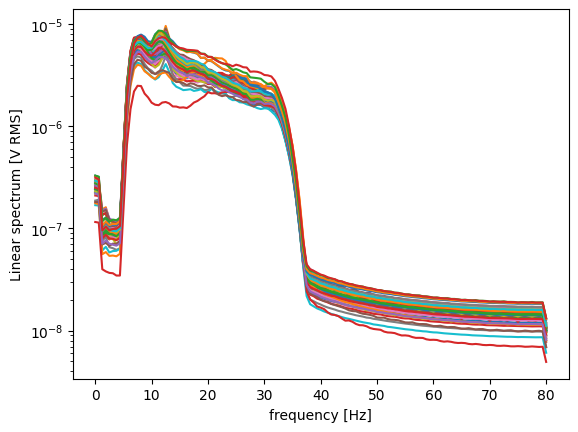

In [131]:
plotPowerSpectrum(freqs, psds)

Effective window size : 12.800 (s)


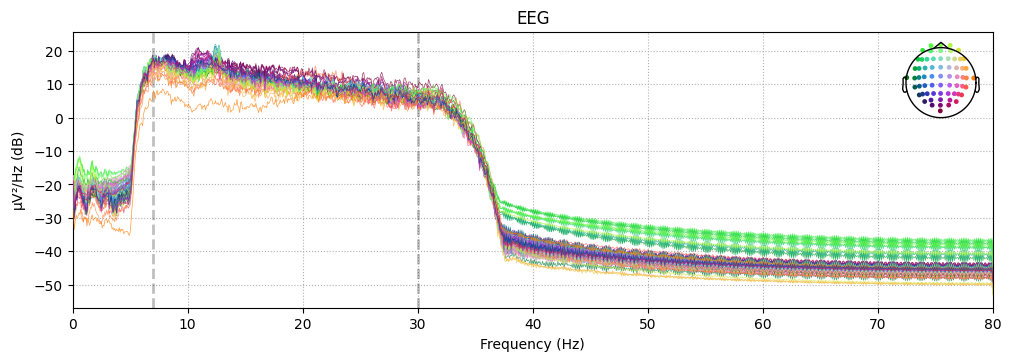

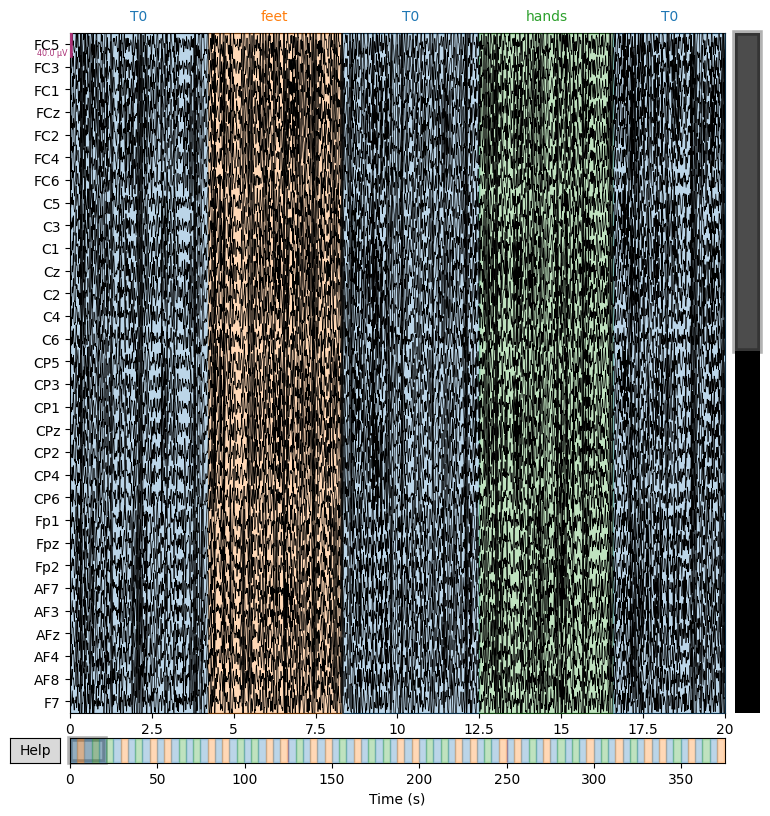

In [132]:
raw_filtered.compute_psd().plot(picks="data", exclude="bads")
raw_filtered.plot(duration=20, n_channels=30)
print()

# Classification
Leveraging the extracted features, this stage employs machine learning or statistical algorithms to categorize the EEG signals into discrete classes. Popular choices are the random forests algorithms for their interpretability and robustness to overfitting. The selection and optimization of the classification algorithm are crucial for maximizing accuracy and generalizability to unseen data.

Used Annotations descriptions: ['feet', 'hands']


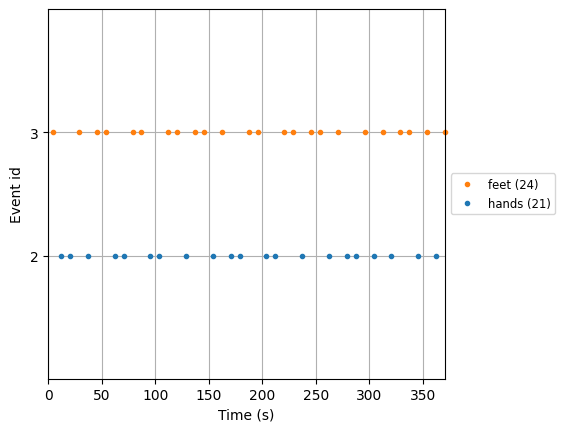

In [133]:
event_ids = dict(hands=2, feet=3)
events, _ = mne.events_from_annotations(raw_filtered, event_id=event_ids)

fig = mne.viz.plot_events(
    events, event_id=event_ids, sfreq=raw_filtered.info["sfreq"]
)
classes = list(event_ids.keys())

In [134]:
tmin, tmax = -1.0, 4.0
picks = pick_types(raw_filtered.info,
                   meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(
    raw_filtered,
    events=events,
    event_id=event_ids,
    tmin=tmin,
    tmax=tmax,
    proj=True,
    baseline=None,
    preload=True,
    picks=picks,
)

epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)

Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped


In [135]:
#df = epochs.to_data_frame()
#df.iloc[:5, :10]

In [136]:
#epochs.drop_bad()
#epochs.plot_drop_log()
#print()

In [137]:
scores = []
epochs_data = epochs.get_data(copy=False)
epochs_data_train = epochs_train.get_data(copy=False)

labels = epochs.events[:, -1] - 2

In [138]:
from sklearn.model_selection import ShuffleSplit

# Define a monte-carlo cross-validation generator (reduce variance):
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

print(epochs_data.shape)
print(epochs_data_train.shape)

(45, 64, 801)
(45, 64, 161)


## Linear Discriminant Analysis

In [139]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.neighbors import (KNeighborsClassifier, NeighborhoodComponentsAnalysis)
from sklearn.pipeline import (make_pipeline, Pipeline)
from sklearn.preprocessing import (StandardScaler, LabelEncoder, MinMaxScaler)
from sklearn.linear_model import LogisticRegression

from mne.decoding import CSP

In [140]:
# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

In [141]:
# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([("CSP", csp), ("LDA", lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

Computing rank from data with rank=None
    Using tolerance 9.7e-05 (2.2e-16 eps * 64 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
  

In [142]:
# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(
    "Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance)
)

Classification accuracy: 0.933333 / Chance level: 0.533333


Computing rank from data with rank=None
    Using tolerance 0.00025 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00026 (2.2e-16 eps * 64 dim * 1.9e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


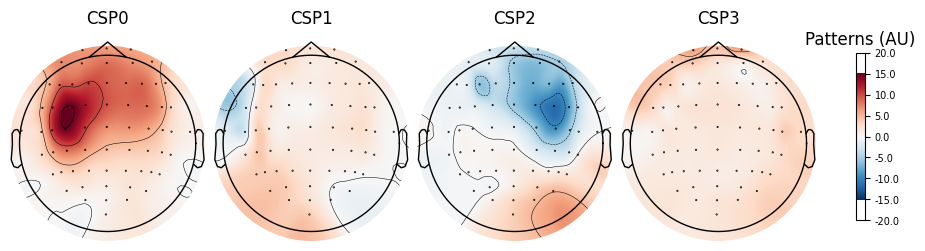

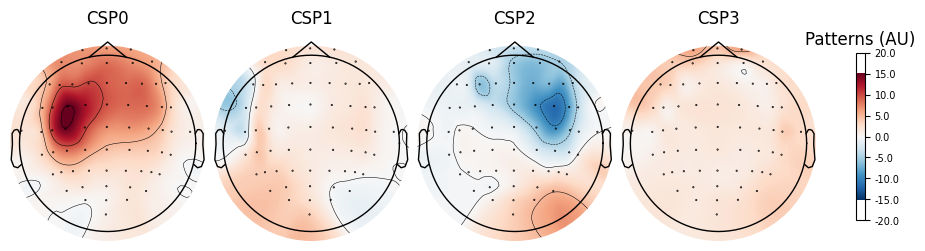

In [143]:
# Plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

In [144]:
sfreq = raw_filtered.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

Computing rank from data with rank=None
    Using tolerance 9.7e-05 (2.2e-16 eps * 64 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
  

### Results




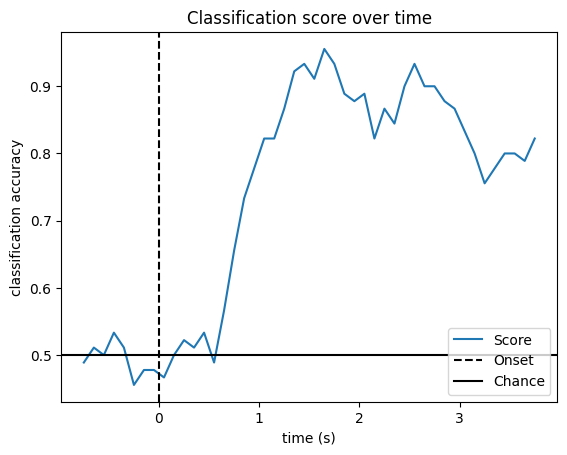

In [145]:
plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()

## K-Neighboors

In [146]:
from collections import Counter

In [147]:
epochs_data = epochs.get_data(copy=False)
labels = epochs.events[:, -1] - 2
class_labels = {}
random_state = 1

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    epochs_data, labels, test_size=0.2, stratify=labels, random_state=random_state
)

class_labels = event_ids | {'hands':0, 'feet':1}

print('Classes:',event_ids)
print('labels:',Counter(labels),'where:',class_labels)
print('y_train:',Counter(y_train))
print('y_test:',Counter(y_test))

Classes: {'hands': 2, 'feet': 3}
labels: Counter({1: 24, 0: 21}) where: {'hands': 0, 'feet': 1}
y_train: Counter({1: 19, 0: 17})
y_test: Counter({1: 5, 0: 4})


First we must choose the best k neighbor value, for this we have to run it repeteadly and choose the best accuracy and k value

In [148]:
k_range = range(1, 20)
scores = []
for k in k_range:
  # Flatten data, Reduce dimensionality
  csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

  # Assemble a classifier
  knn = KNeighborsClassifier(n_neighbors=k)

  # Fit the method's model
  X_train_csp = csp.fit_transform(X_train, y_train)

  # Fit a nearest neighbor classifier on the embedded training set
  knn.fit(X_train_csp, y_train)

  # Compute the nearest neighbor accuracy on the embedded test set
  X_test_csp = csp.transform(X_test)
  scores.append(knn.score(X_test_csp, y_test))

  # Embed the data set in 2 dimensions using the fitted model
  X_embedded = csp.transform(epochs_data)

Computing rank from data with rank=None
    Using tolerance 0.00022 (2.2e-16 eps * 64 dim * 1.6e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00023 (2.2e-16 eps * 64 dim * 1.6e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00022 (2.2e-16 eps * 64 dim * 1.6e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00023 (2.2e-16 eps * 64 dim * 1.6e+10  max singular value)


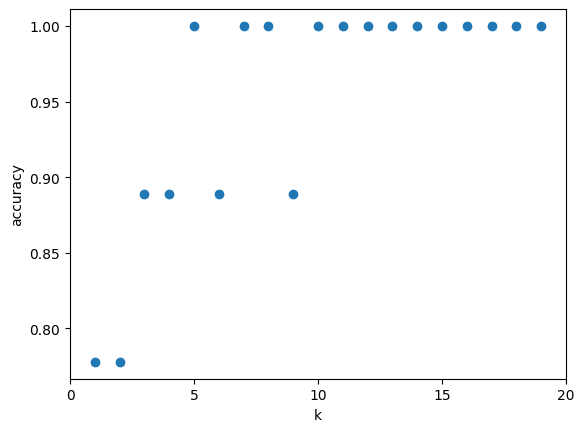

In [149]:
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])
plt.show()
print()

As seen k = 5 is best option. while k=1 also seems to be an option this one wont be good because it wont have enough neighboors

In [150]:
k = 5
# Flatten data, Reduce dimensionality
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Assemble a classifier
knn = KNeighborsClassifier(n_neighbors=k)

# Fit the method's model
X_train_csp = csp.fit_transform(X_train, y_train)

# Fit a nearest neighbor classifier on the embedded training set
knn.fit(X_train_csp, y_train)

# Compute the nearest neighbor accuracy on the embedded test set
X_test_csp = csp.transform(X_test)
acc_knn = knn.score(X_test_csp, y_test)

# Embed the data set in 2 dimensions using the fitted model
X_embedded = csp.transform(epochs_data)

Computing rank from data with rank=None
    Using tolerance 0.00022 (2.2e-16 eps * 64 dim * 1.6e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00023 (2.2e-16 eps * 64 dim * 1.6e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


### Results

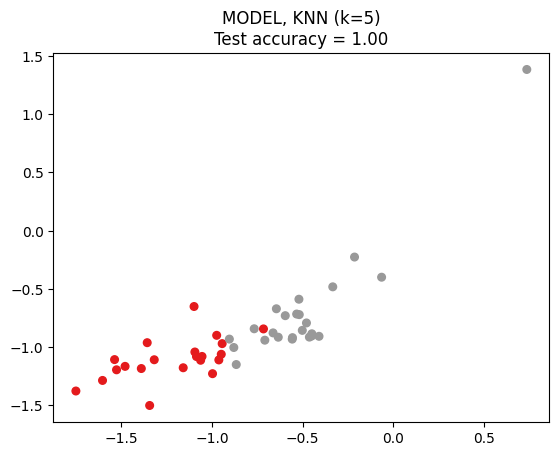

In [151]:
# Plot the projected points and show the evaluation score
plt.figure()
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, s=30, cmap="Set1")
plt.title(
    "{}, KNN (k={})\nTest accuracy = {:.2f}".format('MODEL', k, acc_knn)
)
plt.show()
plt.close()

<Figure size 640x480 with 0 Axes>

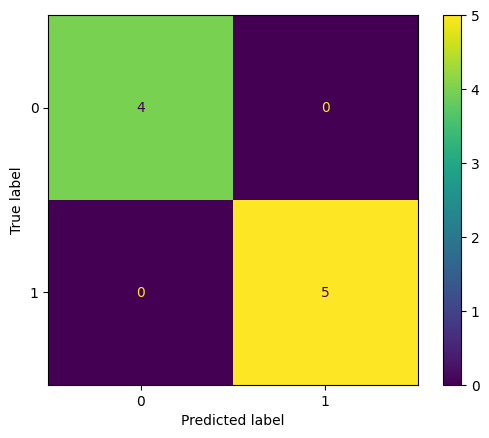

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9




In [152]:
pred_train = knn.predict(csp.transform(X_train))
pred_test  = knn.predict(csp.transform(X_test))

# Plot the confusion matrix and get classification report
plt.figure()
cm = confusion_matrix(y_test, pred_test, labels=clf.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_).plot()
plt.show()

print(classification_report(y_test, pred_test))
print()

In [153]:
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train_csp, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test_csp, y_test)))

Accuracy of K-NN classifier on training set: 0.94
Accuracy of K-NN classifier on test set: 1.00


# Bibliography

1.   M. Gonçales. " The effects of applying filters on EEG signals for classifying developers' code comprehension ," in Journal of Applied Research and Technology , 2021 .
2.   Zoltan J. Koles. "The quantitative extraction and topographic mapping of the abnormal components in the clinical EEG ," Electroencephalography and Clinical Neurophysiology, 79(6):440–447, 1991. doi:10.1016/0013-4694(91)90163-X.
3.  Gerwin Schalk, et al. "BCI2000: a general-purpose brain-computer interface (BCI) system ," IEEE Transactions on Biomedical Engineering, 51(6):1034–1043, 2004. doi:10.1109/TBME.2004.827072.
4. MNE, "Motor imagery decoding from EEG data using the Common Spatial Pattern (CSP) ," [En linea] Disponible en: https://mne.tools/dev/auto_examples/decoding/decoding_csp_eeg.html
5. Juan Ignacio Bagnato, "Clasificar con K-Nearest-Neighbor ejemplo en Python ," Blog: Aprende machine learning [En linea] Disponible en: https://www.aprendemachinelearning.com/clasificar-con-k-nearest-neighbor-ejemplo-en-python/
6. Pedregosa, F. et al, "Dimensionality Reduction with Neighborhood Components Analysis ," Scikit-learn: Machine Learning in Python [En linea] Disponible en: https://scikit-learn.org/stable/auto_examples/neighbors/plot_nca_dim_reduction.html
7. MNE, "Decoding (MVPA) ," [En linea] Disponible en: https://mne.tools/stable/auto_tutorials/machine-learning/50_decoding.html


